In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from random import randrange
from tabulate import tabulate

In [3]:
#common function for data preprocessing of all the catalogs. Drop some columns and convert continuous data into categorical. 
def read(path):
    df = pd.read_csv(path)
    cols = df.columns
    colstodrop = ['Unnamed: 0','Unnamed: 0.1','galex_objid','sdss_objid','pred']
    for i in colstodrop:
        if i in df.columns:
            df=df.drop(i,axis=1)
    cl = df['class']
    redshift = df['spectrometric_redshift']
    df=df.drop(['class','spectrometric_redshift'],axis=1)
    df=df.join(cl).join(redshift)
    #df=df.join(redshift)
    for col in df:
        if col == 'class':
            continue
        df[col] = pd.cut(df[col],100,labels=False)
    return df

In [4]:
df = read('F:/Study/5th sem/ML/MiniProject1_SectionE_G/catalog1/cat1.csv')
df.head()

,u,g,r,i,z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,...,r-z,i-z,fuv-nuv,fuv-u,fuv-g,fuv-r,fuv-i,fuv-z,class,spectrometric_redshift
0,29,21,22,21,19,35,35,35,35,35,...,53,45,31,6,0,0,0,0,0,0
1,82,88,76,62,53,41,41,41,41,41,...,79,54,67,68,62,45,34,29,1,32
2,64,83,89,85,80,30,30,30,30,30,...,39,33,51,30,42,44,43,44,1,26
3,71,90,95,91,82,23,23,23,23,23,...,47,46,55,55,66,64,63,58,1,13
4,83,96,96,86,76,10,10,10,10,10,...,66,52,58,49,50,47,41,36,1,25


In [5]:
# Split a dataset into a train and test set
def train_test_split(df, split):
    df = np.array(df)
    train = list()
    train_size = split * len(df)
    test = list(df)
    while len(train) < train_size:
        index = randrange(len(test))
        train.append(test.pop(index))
    return train, test

In [6]:
#over-sample the minority class in training data
def upsample(train):
    class1=[]
    class0init=[]
    class0up=[]
    for i in train:
        if i[-2] == 1:
            class1.append(i)
        else:
            class0init.append(i)
    class0up=class0init
    while(len(class0up)<len(class1)):
        index = randrange(len(class0init))
        class0up.append(class0init[index])
    return class1+class0up

In [7]:
cols = df.columns
train,test = train_test_split(df,0.8)
train=upsample(train)
gains = []

In [8]:
#Finds distinct values for an attribute
def distinct(df, col):
    l=set()
    for row in df:
        l.add(row[col])
    return list(l)

In [9]:
#counts the number of rows in each level/class in the dataframe
def count_level(df):
    counts = [0,0]
    for row in df:
        level = row[-2]
        counts[level] += 1
    return counts

In [10]:
count_level(train)

[472, 472]

In [11]:
#Query objects can be used to split the dataframe on the basis of the outcome of the query
class Query:
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def check(self, row):
        ans = row[self.column]
        return ans >= self.value

In [12]:
q = Query(1, 20)

In [13]:
example = train[10]
q.check(example)

True

In [14]:
#divide/partition the dataframe into true and false branches based on the outcome of the query
def divide(df, query):
    true_branch = []
    false_branch = []
    for row in df:
        if query.check(row):
            true_branch.append(row)
        else:
            false_branch.append(row)     
    return true_branch, false_branch

In [15]:
#gini impurity = 1-sum(p^2)
def gini_impurity(rows):
    counts = count_level(rows)
    gini = 1
    for ele in counts:
        prob = ele / float(len(rows))
        gini -= pow(prob,2)
    return gini

In [16]:
gini_impurity(train)

0.5

In [17]:
def information_gain(lbranch, rbranch, initgini):
    prob = float(len(lbranch)) / (len(lbranch) + len(rbranch))
    return initgini - prob * gini_impurity(lbranch) - (1 - prob) * gini_impurity(rbranch)

In [18]:
current_uncertainty = gini_impurity(train)
current_uncertainty

0.5

In [19]:
#Find the best query to ask by iterating over every feature / value and calculating the information gain.
def best_query(df,cols):
    bestgain = 0  
    bestquery = None  
    initgini = gini_impurity(df)
    length = len(cols)-2
    for element in range(length): 
        distinctval = distinct(df,element) 
        for val in distinctval:
            q = Query(element, val)
            # try partitioning the dataset
            tbranch, fbranch = divide(df, q)
            # Skip this split if it doesn't divide the dataset.
            if ((len(tbranch) == 0) or (len(fbranch)) == 0):
                continue
            # Calculate the information gain from this split
            gain = information_gain(tbranch, fbranch, initgini)
            if gain >= bestgain:
                bestgain, bestquery = gain, q
    return bestgain, bestquery

In [20]:
#The final decision tree consists of nodes and leaves. Nodes split the data on the best query and leaves contain the predicted
#values
class Leaf:
    def __init__(self, df):
        l = count_level(df)
        self.pred = l.index(max(l))

In [21]:
class Node:
    def __init__(self,query,tbranch,fbranch):
        self.query = query
        self.tbranch = tbranch
        self.fbranch = fbranch

In [22]:
#recursively builds the decison tree
def build_tree(rows):
    gain, query = best_query(rows,cols)
    gains.append(gain)
    # Base case: no further info gain. Since we can ask no further questions, we'll return a leaf.
    if gain == 0:
        return Leaf(rows)
    true_rows, false_rows = divide(rows, query)
    # Recursively build the true branch.
    true_branch = build_tree(true_rows)
    # Recursively build the false branch.
    false_branch = build_tree(false_rows)
    return Node(query, true_branch, false_branch)

In [23]:
mytree = build_tree(train)

In [24]:
#traverse the tree until we reach a leaf
def predict(row, node):
    # Base case: we've reached a leaf. Return the prediction. 
    if isinstance(node, Leaf):
        return node.pred
    if node.query.check(row):
        return predict(row, node.tbranch)
    else:
        return predict(row, node.fbranch)

In [25]:
actual = []
pred = []
red1 = []
red2 = []
red3 = []
pred1 = []
pred2 = []
pred3 = []
for i in test:
    p = predict(i,mytree)
    actual.append(i[-2])
    pred.append(p)
    if i[-1]<=0.0033:
        red1.append(0)
        pred1.append(p)
    elif i[-1]>=0.004:
        red2.append(1)
        pred2.append(p)
    else:
        red3.append(i[-2])
        pred3.append(p)

In [26]:
def confusion_matrix(actual,pred):
    tp=0
    fn=0
    fp=0
    tn=0
    for i in range(len(actual)):
        if(actual[i]==0 and pred[i]==0):
            tp += 1
        elif(actual[i]==0 and pred[i]==1):
            fn += 1
        elif(actual[i]==1 and pred[i]==0):
            fp += 1
        elif(actual[i]==1 and pred[i]==1):
            tn += 1
    conf = [[tp,fn],[fp,tn]]
    return conf

In [27]:
def metrics(conf):
    tp=conf[0][0]
    fn=conf[0][1]
    fp=conf[1][0]
    tn=conf[1][1]
    acc = (tp+tn)/(tp+tn+fp+fn)
    srec = tp/(tp+fn)
    sprec = tp/(tp+fp)
    sfscore = (2*srec*sprec)/(srec+sprec)
    qrec = tn/(tn+fp)
    qprec = tn/(tn+fn)
    qfscore = (2*qrec*qprec)/(qrec+qprec)
    print("Classification Report: \n\n")
    print("Overall accuracy ->",acc)
    print()
    ab=[['Stars',sprec,srec,sfscore],['Quasars',qprec,qrec,qfscore]]
    print(tabulate(ab,headers=['','Precision','Recall','F1-score'],tablefmt='orgtbl'))

In [28]:
def printconf(conf):
    ab = [['Actual Star',conf[0][0],conf[0][1]],['Actual Quasar',conf[1][0],conf[1][1]]]
    print(tabulate(ab,headers=['','Predicted Star','Predicted Quasar'],tablefmt='orgtbl'))

In [29]:
conf = confusion_matrix(actual,pred)
printconf(conf)

|               |   Predicted Star |   Predicted Quasar |
|---------------+------------------+--------------------|
| Actual Star   |                5 |                  1 |
| Actual Quasar |                5 |                118 |


In [30]:
metrics(conf)

Classification Report: 


Overall accuracy -> 0.9534883720930233

|         |   Precision |   Recall |   F1-score |
|---------+-------------+----------+------------|
| Stars   |    0.5      | 0.833333 |   0.625    |
| Quasars |    0.991597 | 0.95935  |   0.975207 |


In [31]:
import sklearn.metrics as smetrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = smetrics.roc_curve(actual, pred)
roc_auc = smetrics.auc(fpr, tpr)

In [32]:
#plot the roc curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 640x480 with 1 Axes>

In [33]:
#confusion matrix for redshift range 1 (z<=0.0033)
conf2 = confusion_matrix(red1,pred1)
#confusion matrix for redshift range 2 (z>=0.004)
conf3 = confusion_matrix(red2,pred2)
#confusion matrix for redshift range 3 (0.0033<z<0.004)
conf4 = confusion_matrix(red3,pred3)

In [34]:
printconf(conf2)

|               |   Predicted Star |   Predicted Quasar |
|---------------+------------------+--------------------|
| Actual Star   |                6 |                  1 |
| Actual Quasar |                0 |                  0 |


In [35]:
printconf(conf3)

|               |   Predicted Star |   Predicted Quasar |
|---------------+------------------+--------------------|
| Actual Star   |                0 |                  0 |
| Actual Quasar |                4 |                118 |


In [36]:
printconf(conf4)

|               |   Predicted Star |   Predicted Quasar |
|---------------+------------------+--------------------|
| Actual Star   |                0 |                  0 |
| Actual Quasar |                0 |                  0 |


In [37]:
#checking if there were any datapoints in the overlapping region of redshift.
print((len(red1)+len(red2))-len(test))

0


In [38]:
print(gains)

[0.17856749657916665, 0.2413124971671618, 0.10372148859543814, 0.07232555671131699, 0.0, 0.03434830065113463, 0.0, 0.02406645569620269, 0.012418392038675757, 0.0004088167096808048, 0.0, 0.07396449704142012, 0, 0, 0, 0, 0.0, 0.02367115429203699, 0.012761924547173335, 0.5, 0.0, 0.0, 0.00878419355868366, 0.48, 0.0, 0.0, 0.0, 0.17959183673469392, 0.3756521739130435, 0.22684310018903586, 0, 0.0, 0.0, 0.0, 0.05696142340517685, 0.16528925619834722, 0, 0.0, 0.020599989291120974, 0.0, 0.007040361467329795, 0, 0.0009242349183345364, 0.0, 0.13265306122448978, 0.0, 0.0]


Text(0, 0.5, 'Information gain')

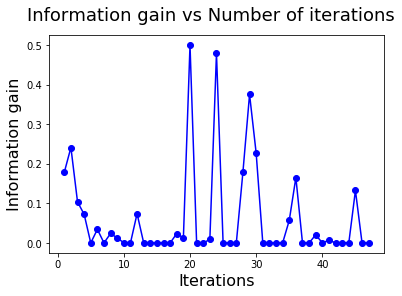

In [39]:
x=range(1,len(gains)+1)
fig = plt.figure()
#plt.axis([0.45, 0.95, 0.85, 0.98])
plt.plot(x,gains, marker='o', color='b')
fig.suptitle('Information gain vs Number of iterations', fontsize=18)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Information gain', fontsize=16)

In [40]:
print("total number of iterations = ",len(gains))

total number of iterations =  47
